# Data Analysis and Exploration

Analyze the raw scraped wiki data to understand structure, attributes, and content characteristics. This notebook provides insights for knowledge graph construction.

## Step 1: Import Libraries

Load required libraries for data processing, visualization, and analysis.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Step 2: Load and Inspect Raw Data

Read the raw wiki data from JSONL file. Each line contains one article with title, content, infobox, and URL. Examine the structure and dimensions of the loaded data.

In [2]:
# Configure visualization and load raw data
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Path to raw scraped data (adjust if folder structure changed)
FILE_PATH = "../data/raw/wiki_dump.jsonl"

data = []
print(f"📂 Loading data from {FILE_PATH}...")

# Read line by line to avoid memory issues with large files
with open(FILE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(data)

print(f"✅ Data loaded successfully. Shape: {df.shape}")
df.head()

📂 Loading data from ../data/raw/wiki_dump.jsonl...
✅ Data loaded successfully. Shape: (5483, 5)


,id,title,url,content,infobox
0,17333,A.J. Kennedy,https://gameofthrones.fandom.com/wiki/?curid=1...,A.J. Kennedy is an actor who portrayed a Frey ...,{}
1,2713,A Golden Crown,https://gameofthrones.fandom.com/wiki/?curid=2713,"""A Golden Crown"" is the sixth episode of the f...","{'Type': 'Thrones', 'Image': 'GOT106.jpg', 'Se..."
2,17755,A Golden Crown/Appearances,https://gameofthrones.fandom.com/wiki/?curid=1...,"A list of individuals, institutions, locations...",{}
3,79113,A Golden Crown (short),https://gameofthrones.fandom.com/wiki/?curid=7...,"""A Golden Crown"" is the sixth short of the fir...",{}
4,68592,A Knight of the Seven Kingdoms,https://gameofthrones.fandom.com/wiki/?curid=6...,A Knight of the Seven Kingdoms is the upcoming...,{}


## Step 3: Analyze Common Infobox Attributes

Identify the most frequent attributes in article infoboxes. These attributes represent potential relationships (edges) in the knowledge graph. Common attributes like 'House', 'Allegiance', and 'Father' indicate important entity connections.

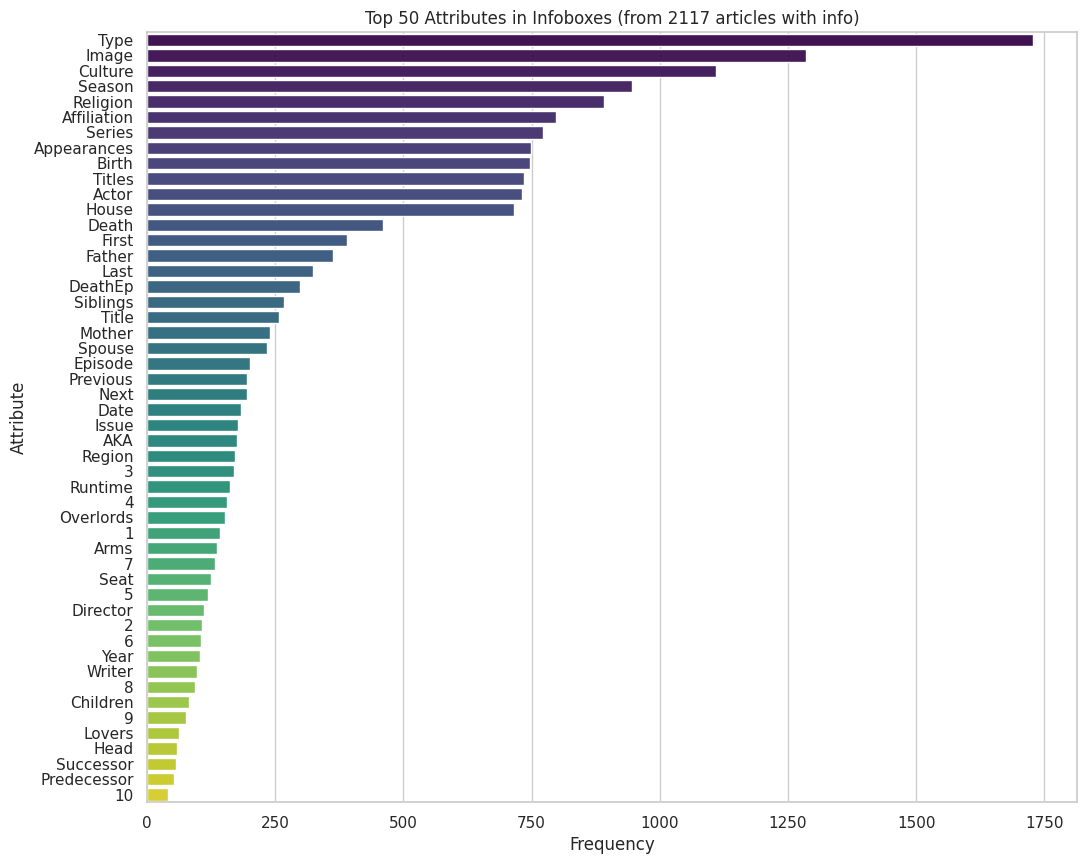

💡 INSIGHT: The most common attributes (e.g., 'House', 'Allegiance', 'Father') should be your Relationships (Edges) in the Knowledge Graph.


In [3]:
# 1. Flatten infoboxes to discover common attributes
# Find out which attributes are most common (e.g., do all characters have 'House'?)
all_keys = []
total_infoboxes = 0

for info in df['infobox']:
    if info:
        total_infoboxes += 1
        all_keys.extend(info.keys())

key_counts = Counter(all_keys)
common_keys_df = pd.DataFrame(key_counts.most_common(50), columns=['Attribute', 'Count'])

# Visualization
plt.figure(figsize=(12, 10))
sns.barplot(data=common_keys_df, x='Count', y='Attribute', palette="viridis", hue='Attribute')
plt.title(f"Top 50 Attributes in Infoboxes (from {total_infoboxes} articles with info)")
plt.xlabel("Frequency")
plt.show()

print("💡 INSIGHT: The most common attributes (e.g., 'House', 'Allegiance', 'Father') should be your Relationships (Edges) in the Knowledge Graph.")

## Step 4: Generate Detailed Attribute Analysis Report

Create a comprehensive JSON report analyzing all attributes in the infoboxes. For each attribute, track relevance score, occurrence count, and top 10 most common values. This helps identify which attributes should become relationship types in the knowledge graph.

In [4]:
import json
import re
import os
from collections import Counter, defaultdict

INPUT_FILE = "../data/raw/wiki_dump.jsonl"  # Adjust if path is different
OUTPUT_JSON = "../data/raw/wiki_attribute_analysis.json"

# Attributes known to be visual noise, not semantic data
BLACKLIST_ATTRIBUTES = {
    "image", "caption", "alt", "imagesize", "bg", "align", 
    "width", "file", "image_size", "bgcolor"
}

def clean_wiki_value(text):
    """
    Clean common MediaWiki artifacts for analysis.
    Example: '[[House Stark|Stark]]' -> 'Stark'
    """
    if not isinstance(text, str):
        return str(text)
    
    # 1. Remove wiki links: [[Text|Visible]] -> Visible, or [[Text]] -> Text
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # 2. Remove simple HTML tags (<br>, <small>)
    text = re.sub(r'<[^>]+>', ' ', text)
    
    return text.strip()

def generate_attribute_report():
    print(f"📂 Reading {INPUT_FILE}...")
    
    # Store all values per attribute for analysis
    attribute_values = defaultdict(list)
    total_articles = 0
    
    # 1. READ AND EXTRACT
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                article = json.loads(line)
                total_articles += 1
                
                infobox = article.get("infobox", {})
                
                for key, val in infobox.items():
                    # Normalize key to lowercase for grouping
                    clean_key = key.strip()
                    
                    # Filter out technical/visual keys
                    if clean_key.lower() in BLACKLIST_ATTRIBUTES:
                        continue
                        
                    # Clean value and store
                    cleaned_val = clean_wiki_value(val)
                    if cleaned_val:  # If not empty
                        attribute_values[clean_key].append(cleaned_val)
                        
            except json.JSONDecodeError:
                continue

    print(f"✅ Processed {total_articles} articles.")
    print("📊 Generating statistics and Top 10...")

    # 2. ANALYSIS AND REPORT STRUCTURE
    final_report = {
        "metadata": {
            "total_articles_scraped": total_articles,
            "total_unique_attributes_found": len(attribute_values)
        },
        "attributes": {}
    }

    # Sort attributes by popularity (how many articles have them)
    sorted_attrs = sorted(attribute_values.items(), key=lambda x: len(x[1]), reverse=True)

    # Keep top 50 attributes for manageable JSON size
    for attr, values_list in sorted_attrs[:50]:
        
        count_obj = Counter(values_list)
        total_occurrences = len(values_list)
        unique_values = len(count_obj)
        
        # Top 10 most common values
        top_10 = count_obj.most_common(10)
        
        # Create readable structure
        final_report["attributes"][attr] = {
            "relevance_score": round((total_occurrences / total_articles) * 100, 2),  # % of articles
            "total_occurrences": total_occurrences,
            "unique_values_count": unique_values,
            "most_common_values": [
                {"value": val, "count": freq, "percentage": round((freq/total_occurrences)*100, 1)}
                for val, freq in top_10
            ]
        }

    # 3. SAVE REPORT
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
        json.dump(final_report, f, indent=4, ensure_ascii=False)

    print(f"✨ Report generated successfully at: {OUTPUT_JSON}")

if __name__ == "__main__":
    generate_attribute_report()

📂 Reading ../data/raw/wiki_dump.jsonl...
✅ Processed 5483 articles.
📊 Generating statistics and Top 10...
✨ Report generated successfully at: ../data/raw/wiki_attribute_analysis.json


# Distribution of Number of Words per Wiki Entry


## Step 5: Analyze Article Length Distribution

Examine the word count distribution across all articles. This helps understand content volume and complexity. We'll compute word counts and visualize the distribution with a histogram, showing that most articles range between 200-2000 words.

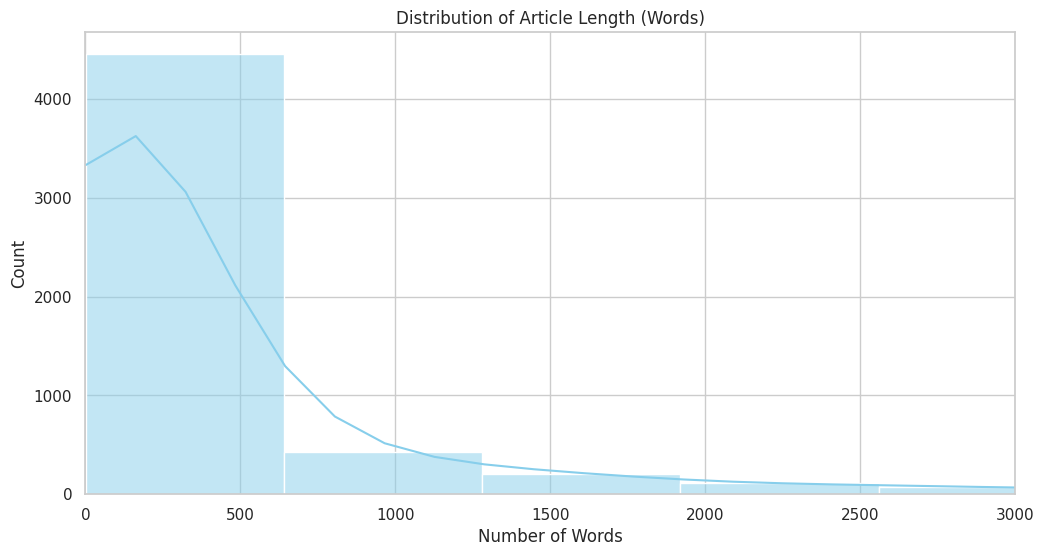

count     5483.000000
mean       589.414554
std       1569.883476
min          2.000000
25%         54.000000
50%        130.000000
75%        438.000000
max      31959.000000
Name: word_count, dtype: float64


In [5]:
# Calculate approximate word count
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# Plot histogram of article length
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Article Length (Words)")
plt.xlabel("Number of Words")
plt.xlim(0, 3000)
plt.show()

# Display key statistics
print(df['word_count'].describe())

## Step 6: Named Entity Recognition Analysis

Use spaCy's English NER model to extract named entities (persons, organizations, locations) from a sample article. This demonstrates what types of entities can be automatically identified and later incorporated into the knowledge graph as nodes and relationships.

In [6]:
import spacy

# Load lightweight English NER model
nlp = spacy.load("en_core_web_sm")

def extract_sample_entities(text):
    # Analyze only first 1000 characters for speed
    doc = nlp(text[:1000])
    return [(ent.text, ent.label_) for ent in doc.ents]

# Select a random article with sufficient content
sample_article = df[df['word_count'] > 200].sample(1).iloc[0]

print(f"🕵️ Analyzing entities in: {sample_article['title']}")
print("-" * 50)
entities = extract_sample_entities(sample_article['content'])

# Filter for Persons (PERSON), Organizations/Houses (ORG), and Locations (GPE)
relevant_ents = [e for e in entities if e[1] in ['PERSON', 'ORG', 'GPE']]
print(relevant_ents[:15])  # Display first 15 entities found

🕵️ Analyzing entities in: Tytos Lannister
--------------------------------------------------
[('Tytos Lannister', 'PERSON'), ('Casterly Rock', 'GPE'), ('House', 'ORG'), ('Jeyne Marbrand', 'GPE'), ('Genna', 'PERSON'), ('Tygett Lannister', 'PERSON'), ('Tyrion Lannister', 'PERSON'), ('Casterly Rock', 'GPE'), ('House', 'ORG'), ('Westeros', 'GPE'), ('Westeros', 'GPE'), ('Tywin', 'PERSON'), ('Kevan', 'PERSON'), ('Cersei, Jaime, Tyrion', 'ORG'), ('Lancel', 'GPE')]
